# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import torch

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("/content/cleaned_ghc_train.csv")


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

df['text'] = df['text'].fillna('')

In [3]:
y = df['label']
X=df['text']

In [4]:
#spliting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# **Bert With LSTM**

Here i have tried using bert embeedings that is passed to 3 Biderectional LSTM model.
The reason i have chosen bidirectional LSTM because bidirectional LSTM processes the sequence in both forward and backward directions, capturing information from both past and future contexts. This allows the model to have a more comprehensive understanding of the context.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

Epoch 1/5
1089/1089 [==============================] - 430s 380ms/step - loss: 0.5458 - accuracy: 0.7334 - val_loss: 0.4262 - val_accuracy: 0.7961
Epoch 2/5
1089/1089 [==============================] - 413s 379ms/step - loss: 0.4850 - accuracy: 0.7778 - val_loss: 0.6293 - val_accuracy: 0.6905
Epoch 3/5
1089/1089 [==============================] - 409s 375ms/step - loss: 0.4497 - accuracy: 0.7967 - val_loss: 0.4342 - val_accuracy: 0.7713
Epoch 4/5
1089/1089 [==============================] - 417s 383ms/step - loss: 0.4234 - accuracy: 0.7994 - val_loss: 0.4178 - val_accuracy: 0.8168
Epoch 5/5
1089/1089 [==============================] - 412s 379ms/step - loss: 0.3887 - accuracy: 0.8159 - val_loss: 0.4022 - val_accuracy: 0.8097
137/137 - 6s - loss: 0.4022 - accuracy: 0.8097 - 6s/epoch - 42ms/step

Test accuracy: 0.8096877932548523
137/137 [==============================] - 7s 44ms/step


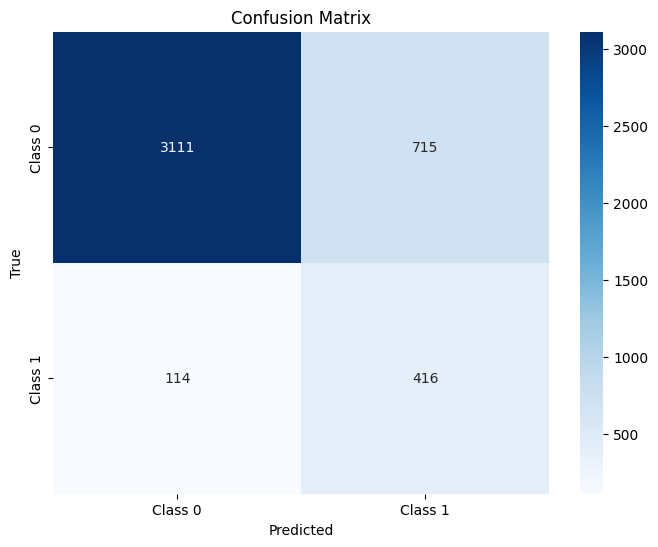

              precision    recall  f1-score   support

     Class 0       0.96      0.81      0.88      3826
     Class 1       0.37      0.78      0.50       530

    accuracy                           0.81      4356
   macro avg       0.67      0.80      0.69      4356
weighted avg       0.89      0.81      0.84      4356



In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode the text data
#Function to tokenize and encode the text data using the BERT tokenizer with truncation and padding.
def encode_texts(texts, tokenizer, max_length=100):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )
    return encodings

# Encode the training and test data
X_train_encodings = encode_texts(X_train, tokenizer, max_length=50)  # Reduced max_length
X_test_encodings = encode_texts(X_test, tokenizer, max_length=50)

# Extract BERT embeddings
def get_bert_embeddings(encodings, bert_model):
    outputs = bert_model(encodings['input_ids'], attention_mask=encodings['attention_mask'])
    return outputs.last_hidden_state

# Reduce the batch size
batch_size = 16

X_train_embeddings = []#empty embeddings intialisation
#looping through batches
for i in range(0, len(X_train_encodings['input_ids']), batch_size):
    batch_encodings = {key: val[i:i+batch_size] for key, val in X_train_encodings.items()}# Slice the encodings dictionary to get a batch
    batch_embeddings = get_bert_embeddings(batch_encodings, bert_model) # Get BERT embeddings for the batch
    X_train_embeddings.append(batch_embeddings) # Append the batch embeddings to the list
X_train_embeddings = tf.concat(X_train_embeddings, axis=0)# Concatenate all batch embeddings to form the final training embeddings tensor

X_test_embeddings = []
for i in range(0, len(X_test_encodings['input_ids']), batch_size):
    batch_encodings = {key: val[i:i+batch_size] for key, val in X_test_encodings.items()}
    batch_embeddings = get_bert_embeddings(batch_encodings, bert_model)
    X_test_embeddings.append(batch_embeddings)
X_test_embeddings = tf.concat(X_test_embeddings, axis=0)
#class weights are calculated based on the frequency of each class in the training data. Classes with fewer samples get higher weights.
#The compute_class_weight function in scikit-learn calculates these weights using the formula.since for large datset it is complex to manually calculate the weights and assing them, this function of sklearn helps in doing it.
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)#calculates the weights for each class in a way that balances the dataset.
class_weights_dict = dict(enumerate(class_weights))

# Define the model
model = Sequential()
#in the model, I tried removing dropouts at each layer and adding them in the end, but it did not give a good result.
#so i modified it and tried decreasing the dropouts at each layer which gave best result so far
# BiLSTM layers
model.add(Bidirectional(LSTM(units=256, return_sequences=True, input_shape=(X_train_embeddings.shape[1], X_train_embeddings.shape[2]))))
model.add(Dropout(0.5))  # Add Dropout

# Additional BiLSTM layer
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.3))  # Decreasing dropout

# Another BiLSTM layer
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.2))  # Add Dropout

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Add Dropout
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and class weights
history = model.fit(X_train_embeddings, y_train, epochs=5, batch_size=batch_size,
                    validation_data=(X_test_embeddings, y_test),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_embeddings, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Predict the labels for the test set
y_pred = model.predict(X_test_embeddings)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))


In [6]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
# Calculate and print additional metrics
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.8096877869605142
Recall: 0.7849056603773585
Precision: 0.367816091954023
F1 Score: 0.5009030704394943
ROC AUC Score: 0.8779601337423191


This model gives the highest ROC AUC score among all other dl model and also gives better result than ml model.The recall tells that the model is able to predict the actual two classes correctly at a good rate.